**From a series of application of modern interpolation methods for economics: written by [Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)**

# Goal of this notebook
This notebook solves a linear–quadratic (LQ) control problem drawn from Chapter 5 of **[Ljungqvist and Sargent (2018)](https://www.sfu.ca/~kkasa/Recursive_Macroeconomic_Theory_Ljungqvist_Sargent_2018.pdf)**, using **neural networks**.

## General setup
The general setup of a linear–quadratic (LQ) control problem is given by

$$
\begin{align}
v(x) &= \max_{u}\Bigl\{ -x^\top R x - u^\top Q u 
+ \beta \mathbb{E}\bigl[ v(x') \bigr] \Bigr\} \\
\text{s.t. } \quad x' &= A x + B u + C \epsilon', \\
\qquad x_0 &\text{ is given},
\end{align}
$$

where 
- $x \in \mathbb{R}^n$,
- $u \in \mathbb{R}^m$,  
- $\epsilon' \sim \mathcal{N}(0, I_n)$,  
- $A \in \mathbb{R}^{n \times n}$,  
- $B \in \mathbb{R}^{n \times m}$, and  
- $C \in \mathbb{R}^{n \times n}$.

The reward is **quadratic** in the state $x$ and the control $u$, and the state evolves **linearly**.


The solution takes the form
$$
\begin{align}
v(x) &= -x^\top P x - d, \\
u(x) &= -F x,
\end{align}
$$

where 
- $P \in \mathbb{R}^{n \times n}$,
- $F \in \mathbb{R}^{m \times n}$, and  
- $d \in \mathbb{R}$.

$P$ solves the *algebraic matrix Riccati equation*:

$$
\begin{align*}
P
= R
+ A^\top P A
- A^\top P B \left( Q + B^\top P B \right)^{-1} B^\top P A .
\end{align*}
$$

The optimal feedback matrix $F$ is given by

$$
\begin{align*}
F = \left( Q + B^\top P B \right)^{-1} B^\top P A .
\end{align*}
$$

The constant term $d$ is given by

$$
\begin{align*}
d = \frac{\beta}{1 - \beta} \, \operatorname{trace}\!\left( P C C^\top \right) .
\end{align*}
$$


## Specific Example (Exercise 5.11)

Consider a competitive firm that produces output $y_t$ and sells it at price $p_t$. The firm chooses its production plan to maximize the discounted sum of profits:

$$
\begin{align*}
\sum_{t=0}^{\infty} \beta^t R_t,
\end{align*}
$$

where the period profit (reward) is given by
$$
\begin{align*}
R_t = p_t y_t - \frac{1}{2} \gamma \, (y_{t+1} - y_t)^2,
\end{align*}
$$
with $y_0$ as a known initial output level. 

Here, $\beta \in (0,1)$ represents the discount factor, and $\gamma>0$ captures the cost of changing the production level.

The firm is a price taker, and the market price is determined by the aggregate demand:

$$
\begin{align*}
p_t = \alpha_0 - \alpha_1 Y_t,
\end{align*}
$$

where $\alpha_0, \alpha_1 > 0$, and $Y_t$ denotes total market output, equal to the sum of outputs from $n$ identical firms.

The firm expects the market-wide output to evolve according to

$$
\begin{align*}
Y_{t+1} = h_0 + h_1 Y_t,
\end{align*}
$$

with a known initial condition $Y_0$. At each time $t$, the firm observes both $Y_t$ and its own output $y_t$ before choosing the next period's output $y_{t+1}$.

---
### LQ formulation
In this case 
- $x = \begin{pmatrix} 1\\y\\Y\end{pmatrix}$,
  
- $R = \begin{bmatrix}
0 & -\tfrac{\alpha_0}{2}& 0\\
-\tfrac{\alpha_0}{2} & 0 & \tfrac{\alpha_1}{2}\\
0 & \tfrac{\alpha_1}{2} & 0
\end{bmatrix}$,

- $Q = \tfrac{\gamma}{2}$,
  
- $A=\begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
h_0 & 0 & h_1
\end{bmatrix}$,

- $B = \begin{bmatrix}
0\\1\\0
\end{bmatrix}$, and

- $C = \begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix}$.

---
To solve this problem using a neural network, we start from the Euler equation:

### Euler equation

$$
\begin{align}
\gamma u(y,Y) = \beta \big[\gamma u(y',Y') + (\alpha_0 - \alpha_1 Y') \big]
\end{align}
$$

Examining the Euler equation more carefully, we see that the policy function $u(\cdot)$ does not depend on $y$. Therefore, the Euler equation can be simplified to

$$
\begin{align}
\gamma u(Y) = \beta \big[\gamma u(Y') + (\alpha_0 - \alpha_1 Y') \big]
\end{align}
$$


## Neural Networks Implementation

1. **Choose neural networks**  
   Select a neural network to represent the policy $u(Y;\theta_u)$ and another neural network for the value function $v(y,Y;\theta_v)$, where $\theta_u$ and $\theta_v$ denote the parameters of the networks.

2. **Discretize the state space**  
   We discretize the $(y,Y)$ space as
   $$
   \mathcal{D} = \{y_1, \dots, y_{n_y}\} \times \{Y_1, \dots, Y_{n_Y}\}
   = \{(y_1,Y_1), \dots, (y_n,Y_n)\},
   $$
   where $n = n_y \cdot n_Y$.

3. **Define the Euler residual**  
   $$
   \ell_{\text{Euler}}(Y_i;\theta_u)
   = \gamma u(Y_i;\theta_u)
   - \beta \Big[\gamma u(Y'_i;\theta_u) + (\alpha_0 - \alpha_1 Y'_i) \Big],
   $$
   with $Y'_i = h_0 + h_1 Y_i$.

4. **Solve the minimization problem (Euler)**  
   $$
   \min_{\theta_u} \frac{1}{n_Y} \sum_{i=1}^{n_Y}
   \left[\ell_{\text{Euler}}(Y_i;\theta_u)\right]^2 .
   $$

   Let $\theta_u^*$ denote the solution to this minimization problem.

5. **Define the Bellman residual**
   $$
   \ell_{\text{Bellman}}(y_i,Y_i;\theta_v)
   = v(y_i,Y_i;\theta_v)
   - \Big[
   -\frac{\gamma}{2} u(Y_i;\theta_u^*)^2
   + (\alpha_0 - \alpha_1 Y_i)y_i
   + \beta v(y'_i,Y'_i;\theta_v)
   \Big],
   $$
   where $Y'_i = h_0 + h_1 Y_i$ and
   $y'_i = y_i + u(Y_i;\theta_u^*)$.

6. **Solve the minimization problem (Bellman)**
   $$
   \min_{\theta_v} \frac{1}{n}
   \sum_{(y_i,Y_i)\in \mathcal{D}}
   \left[\ell_{\text{Bellman}}(y_i,Y_i;\theta_v)\right]^2 .
   $$
   Let $\theta_v^*$ denote the solution to this minimization problem.

### Testing and Test Data

Given the initial conditions $y_0$ and $Y_0$,  the approximate policy
$u(Y;\theta_u^*)$, and the approximate value function $v(y, Y;\theta_v^*)$:

1. **Generate the path of $Y$**
   $$
   Y_{t+1} = h_0 + h_1 Y_t .
   $$

2. **Generate the policy path**
   $$
   \hat{u}_t = u(Y_t;\theta_u^*) .
   $$

3. **Generate the path of $y$**
   $$
   \hat{y}_{t+1} = \hat{y}_t + \hat{u}_t .
   $$

4. **Generate the value function path**
   $$
   \hat{v}_t = v(y_t, Y_t;\theta_v^*) .
   $$


We compare $\hat{u}_t$ and $\hat{v}_t$ with the solution obtained from an LQ solver.

In [1]:
# Importing packages

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

# For benchmark solution
import quantecon as qe
from quantecon import LQ

In [3]:
# Economic paramters
def get_parameters(beta=0.9,
                   alpha_0=1.0,
                   alpha_1=1.3,
                   gamma=90.0,
                   h_0=0.05,
                   h_1=0.9,
                   y_0=0.1,
                   Y_0=0.1):
 #h_0 and h_1 are set such that Y_bar = 1
    params = {
        'beta': beta,
        'alpha_0': alpha_0,
        'alpha_1': alpha_1,
        'gamma': gamma,
        'h_0': h_0,
        'h_1': h_1,
        'y_0': y_0,
        'Y_0': Y_0
    }

    return params

In [4]:
# Training data

def grid_D(params, grid_num_y, grid_num_Y, y_upper_bound, Y_upper_bound):
    y_0 = params["y_0"]
    Y_0 = params["Y_0"]
    grid_y = torch.linspace(y_0, y_upper_bound, steps = grid_num_y).unsqueeze(dim=1)
    grid_Y = torch.linspace(Y_0, Y_upper_bound, steps = grid_num_Y).unsqueeze(dim=1)
    grid_yY = torch.cartesian_prod(grid_y.squeeze(), grid_Y.squeeze())
    #creating the state for LQ, testing and policy error
    ones = torch.ones([len(grid_y)*len(grid_Y),1])
    state = torch.cat((ones,grid_yY), dim =1).T
    
    return grid_yY, grid_y, grid_Y

In [5]:
# Test data

In [6]:
def test_data(params, u_theta, time_period):
    y_0 = params["y_0"]
    Y_0 = params["Y_0"]

    y_hat_t = torch.zeros(time_period, 1)
    Y_t = torch.zeros(time_period, 1)

    h_0 = params["h_0"]
    h_1 = params["h_1"]

    y_hat_t[0] = y_0
    Y_t[0] = Y_0


    for t in range(1, time_period): # constructing Y_t
        Y_t[t] = h_0 + h_1 * Y_t[t-1]
    
    u_theta.eval() 

    with torch.no_grad(): # Constructing u_hat_t
        u_hat_t = u_theta(Y_t)

    for t in range(1, time_period): # Constructing y_t using u_hat_t
            y_hat_t[t] = y_hat_t[t-1] + u_hat_t[t-1]
        
    yY_t = torch.cat((y_hat_t,Y_t), dim = 1)
    return yY_t, y_hat_t, Y_t, u_hat_t

In [7]:
# Euler and Bellman Residuals
def euler_residual(params,u_theta,Y):
    α_0 = params["alpha_0"]
    α_1 = params["alpha_1"]
    β = params["beta"]
    h_0 = params["h_0"]
    h_1 = params["h_1"]
    γ = params["gamma"]
    Y_prime = h_0 + h_1 * Y
    P_prime = α_0 - α_1 * Y_prime
        
    lhs_euler = γ * u_theta(Y)
    rhs_euler = β * (P_prime + γ * u_theta(Y_prime))
    residual_euler = rhs_euler - lhs_euler
    return residual_euler

def bellman_residual(params,u_theta,v_theta,yY):
    α_0 = params["alpha_0"]
    α_1 = params["alpha_1"]
    β = params["beta"]
    h_0 = params["h_0"]
    h_1 = params["h_1"]
    γ = params["gamma"]
    
    y = yY[:,[0]]
    Y = yY[:,[1]]
    
    with torch.no_grad():
        u = u_theta(Y)
        
    y_prime = y + u
    Y_prime = h_0+ h_1*Y
    P = α_0 - (α_1*Y)
    yY_prime = torch.cat((y_prime,Y_prime), dim = 1)
    lhs_bellman = v_theta(yY)
    rhs_bellman = -(γ/2)*(u**2)+ (P*y) + β*v_theta(yY_prime)
    residual_bellman = rhs_bellman - lhs_bellman
    return residual_bellman   

In [8]:
# Neural net

In [9]:
class NN(nn.Module):
    def __init__(self,
                 input_dim = 1,
                 dim_hidden=128,
                 layers=2,
                 hidden_bias=True,
                 hidden_activation=nn.Tanh,
                 softplus_beta = 1.0,
                 positivity = False,
                 seed=123):
        super().__init__()
        self.input_dim = input_dim
        self.dim_hidden = dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        self.hidden_activation = hidden_activation
        self.softplus_beta = softplus_beta
        self.positivity = positivity
        self.seed = seed

        # Set seed if provided
        if self.seed is not None:
            torch.manual_seed(self.seed)
        
        module = []
        
        # First layer
        module.append(nn.Linear(self.input_dim, self.dim_hidden, bias=self.hidden_bias))
        module.append(self.hidden_activation())

        # Additional hidden layers
        for _ in range(self.layers - 1):
            module.append(nn.Linear(self.dim_hidden, self.dim_hidden, bias=self.hidden_bias))
            module.append(self.hidden_activation())

        # Output layer + Softplus (hard-coded)
        module.append(nn.Linear(self.dim_hidden, 1))
        if self.positivity:
            module.append(nn.Softplus(beta=softplus_beta))  # y >= 0

        self.q = nn.Sequential(*module)

    def forward(self, x):
        return self.q(x)

## Solving Euler Equation

In [10]:
# Econ params

In [11]:
param = get_parameters()

In [12]:
# Training data and data loader


In [13]:
yY_train, y_train, Y_train = grid_D(params=param, grid_num_y=12, grid_num_Y=12, y_upper_bound=1.2, Y_upper_bound=0.5)

data_loader_euler = DataLoader(torch.utils.data.TensorDataset(Y_train), batch_size=len(Y_train), shuffle=False)

In [14]:
# Initializing Neural Network

In [15]:
u_theta = NN(input_dim = 1, layers= 1, dim_hidden= 512, hidden_activation = nn.ReLU, seed = 1)

In [16]:
# Setting up the optimizer

In [17]:
num_epochs_euler = 3001
print_frequency = 1000

optimizer_euler = torch.optim.AdamW(u_theta.parameters(), lr=1e-3)
scheduler_euler = torch.optim.lr_scheduler.StepLR(optimizer_euler, step_size=100, gamma=0.95)

In [18]:
for epoch in range(num_epochs_euler):
    for (Y,) in data_loader_euler:
        optimizer_euler.zero_grad()

        residual_euler = euler_residual( params=param, u_theta=u_theta, Y=Y)

        loss_euler = (residual_euler**2).mean()


        loss_euler.backward()
        optimizer_euler.step()

    scheduler_euler.step()

    if epoch % print_frequency == 0:
        print(f"epoch = {epoch}, loss_Euler = {loss_euler.item():.2e}")

epoch = 0, loss_Euler = 1.07e-01
epoch = 1000, loss_Euler = 6.84e-12
epoch = 2000, loss_Euler = 2.21e-11
epoch = 3000, loss_Euler = 1.77e-11


In [19]:
# Testing

In [20]:
yY_t, y_hat_t, Y_t, u_hat_t = test_data(params = param, u_theta = u_theta, time_period = 24)

## Solving Bellman Equation

In [21]:
# Initializing neural network
v_theta = NN(input_dim = 2, layers= 1, dim_hidden= 512, hidden_activation = nn.ReLU, positivity = True , seed = 123)

In [22]:
data_loader_bellman= DataLoader(yY_train, batch_size=len(yY_train), shuffle= False)
num_epochs_bellman = 3001

In [23]:
learning_rate_bellman = 1e-3
optimizer_bellman = torch.optim.AdamW(v_theta.parameters(), lr=learning_rate_bellman)  
scheduler_bellman = torch.optim.lr_scheduler.StepLR(optimizer_bellman, step_size=100, gamma=0.99)

In [24]:
for epoch in range(num_epochs_bellman):
    for data in data_loader_bellman:
        optimizer_bellman.zero_grad() # Resetting the gradients

        residual_Bellman = bellman_residual(params = param,u_theta = u_theta, v_theta = v_theta, yY = data)
        loss_bellman = (residual_Bellman**2).mean()
            
        loss_bellman.backward() # Calculating the gradients (with respect to NN coefficients)
        optimizer_bellman.step() # Using the gradients to minimize the loss function
    scheduler_bellman.step() # Dampening the learning rate
    
    if epoch % print_frequency == 0:
        print(f"epoch = {epoch}, loss_Bellman = {loss_bellman.detach().numpy():.2e}")

epoch = 0, loss_Bellman = 9.91e-02
epoch = 1000, loss_Bellman = 5.41e-06
epoch = 2000, loss_Bellman = 2.07e-06
epoch = 3000, loss_Bellman = 7.35e-07


In [25]:
## Test data

In [26]:
v_theta.eval()
with torch.no_grad():
    v_hat_t = v_theta(yY_t)

## Solution from an LQ Solver

In [27]:
def LQ_theory(y,Y, params, time_periods):
    # y : n by 1 tensor, is the state vector
    # Y :  n by 1 tensor, is the state vector
    β = params["beta"]
    α_0 = params["alpha_0"]
    α_1 = params["alpha_1"]
    γ = params["gamma"]
    h_0 = params["h_0"]
    h_1 = params["h_1"]
    y_0 = params["y_0"]
    Y_0 = params["Y_0"]
    
    R = np.matrix([[0.0,-α_0/2 , 0.0],[-α_0/2, 0.0, α_1/2],[0.0,α_1/2, 0.0]])
    Q = γ/2
    A = np.matrix([[1.0,0.0,0.0],[0.0,1.0,0.0],[h_0,0.0, h_1]])
    B = np.matrix([[0.0],[1.0],[0.0]])
    lq = LQ(Q, R, A, B, beta = β)
    P, F, d = lq.stationary_values()

    P_tens = torch.tensor(P, dtype=torch.float32)      # (n, n)
    F_tens = torch.tensor(F, dtype=torch.float32)      # (1, n)
    d_tens = torch.tensor(d, dtype=torch.float32)
    
    x_0 = np.matrix([[1.0],[y_0],[Y_0]])
    dynamics = lq.compute_sequence(x_0, time_periods-1)
        
    ones = dynamics[0][0].reshape([time_periods,1])
    y_t = dynamics[0][1].reshape([time_periods,1])
    Y_t = dynamics[0][2].reshape([time_periods,1])

    ones = np.ones([len(y_t),1])
    x_t = np.concatenate((ones, y_t, Y_t), axis=1).T
    u_t = (-F@x_t).T

    ones_tens = torch.ones([len(y), 1])
    x_tensor = torch.cat((ones_tens,y,Y), dim =1).T

    v_tens = -(x_tensor.T @ P_tens @ x_tensor)
    v_tens_result = torch.diag(v_tens).unsqueeze(dim =1)
    u_tens = (-F_tens@x_tensor).T # 3\times n
    return v_tens_result, y_t,Y_t, u_tens
    

In [28]:
v_t, _ , _ , u_t = LQ_theory(y = y_hat_t, Y = Y_t, params = param, time_periods = 24)


## Plotting the results

In [29]:
fontsize= 14
ticksize = 14
figsize = (10, 8)
params_fig = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params_fig)

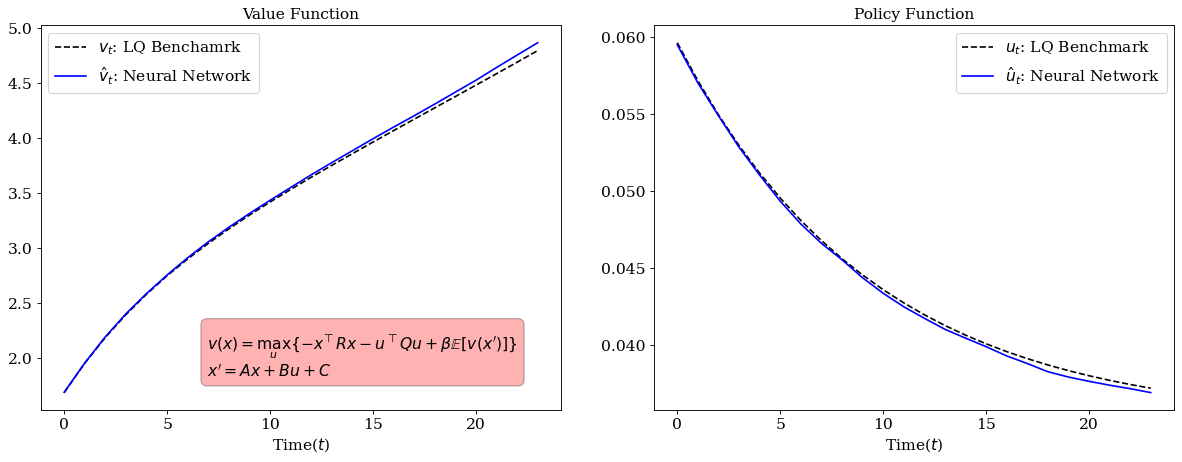

In [60]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: value functions
axes[0].plot(v_t, linestyle="--", color= "k" , label= r"$v_t$: LQ Benchamrk")
axes[0].plot(v_hat_t, color = "b", label=r"$\hat{v}_t$: Neural Network")
axes[0].set_title("Value Function")

axes[0].text(
    0.32, 0.2,
    r"$v(x) = \max_{u}\{ -x^\top R x - u^\top Q u + \beta \mathbb{E}[v(x')] \}$"
    "\n"
    r"$x' = A x + B u + C$",
    transform=axes[0].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round,pad=0.4",
        facecolor="red",
        edgecolor="black",
        alpha=0.3
    )
)

axes[0].set_xlabel("Time($t$)")
axes[0].legend()

# Right panel: policies
axes[1].plot(u_t, color = "k", linestyle = "--", label=r"$u_t$: LQ Benchmark")
axes[1].plot(u_hat_t, color = "b",  label=r"$\hat{u}_t$: Neural Network")
axes[1].set_xlabel("Time($t$)")
axes[1].set_title("Policy Function")
axes[1].legend()

plt.tight_layout()
plt.show()
